In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
import matplotlib.pyplot as plt

In [3]:
data = yf.download('AAPL', start='2018-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [4]:
data = data.drop(columns = 'Adj Close')

In [5]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,82271200


In [20]:
def gen_alpha(data):
    windows = 7
    data['Disparity Index'] = (data['Close'] - data['Close'].rolling(window=windows).mean())/data['Close'].rolling(window=windows).mean()
    
    #Klinger Oscillator
    short_period=34
    long_period=55
    signal_period=13
    data['Trend'] = np.where(
        (data['High'] + data['Low'] + data['Close']) > (data['High'].shift(1) + data['Low'].shift(1) + data['Close'].shift(1)), 
        1, -1
    )

    data['dm'] = data['High'] - data['Low']

    data['cm'] = 0.0
    for i in range(1, len(data)):
        if data['Trend'].iloc[i] == data['Trend'].iloc[i - 1]:
            data['cm'].iloc[i] = data['cm'].iloc[i - 1] + data['dm'].iloc[i]
        else:
            data['cm'].iloc[i] = data['dm'].iloc[i - 1] + data['dm'].iloc[i]

    data['VF'] = data['Volume'] * (2 * (data['dm'] / data['cm'] - 1)) * data['Trend'] * 100

    data['Short EMA'] = data['VF'].ewm(span=short_period, adjust=False).mean()
    data['Long EMA'] = data['VF'].ewm(span=long_period, adjust=False).mean()

    data['Klinger Oscillator'] = data['Short EMA'] - data['Long EMA']

    data['Signal Line'] = data['Klinger Oscillator'].ewm(span=signal_period, adjust=False).mean()
    
    data['100-day SMA'] = data['Close'].rolling(window=100).mean()
    
    
    

In [24]:
gen_alpha(data)
data.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_12268\1145748745.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cm'].iloc[i] = data['dm'].iloc[i - 1] + data['dm'].iloc[i]
C:\Users\DELL\AppData\Local\Temp\ipykernel_12268\1145748745.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cm'].iloc[i] = data['cm'].iloc[i - 1] + data['dm'].iloc[i]


,Open,High,Low,Close,Volume,Disparity Index,Trend,dm,cm,VF,Short EMA,Long EMA,Klinger Oscillator,Signal Line,100-day SMA
Date,,,,,,,,,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600,NaN,-1,0.760002,0.000000,-inf,NaN,NaN,NaN,NaN,NaN
2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600,NaN,1,0.647499,1.407501,-1.275092e+10,-1.275092e+10,-1.275092e+10,0.000000e+00,0.000000e+00,NaN
2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400,NaN,-1,0.347500,0.994999,1.167952e+10,-1.135489e+10,-1.187840e+10,5.235093e+08,7.478705e+07,NaN
2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000,NaN,1,0.579998,0.927498,-7.091636e+09,-1.111128e+10,-1.170745e+10,5.961681e+08,1.492701e+08,NaN
2018-01-08,43.587502,43.902500,43.482498,43.587502,82271200,NaN,1,0.420002,1.347500,-1.132562e+10,-1.112353e+10,-1.169381e+10,5.702833e+08,2.094148e+08,NaN


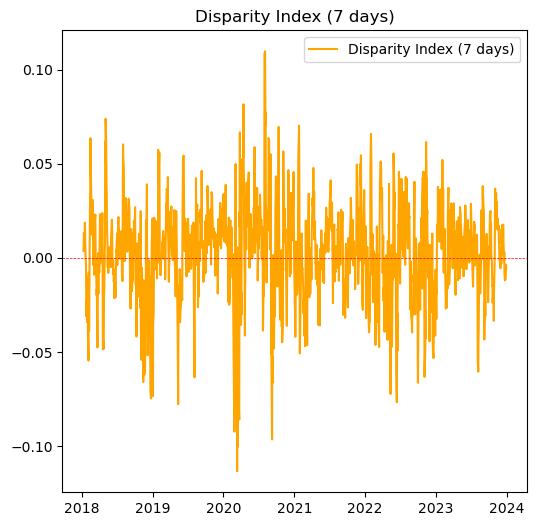

In [21]:
plt.figure(figsize=(6, 6))
plt.plot(data['Disparity Index'], label='Disparity Index (7 days)', color='orange')
plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
plt.title('Disparity Index (7 days)')
plt.legend()
plt.show()

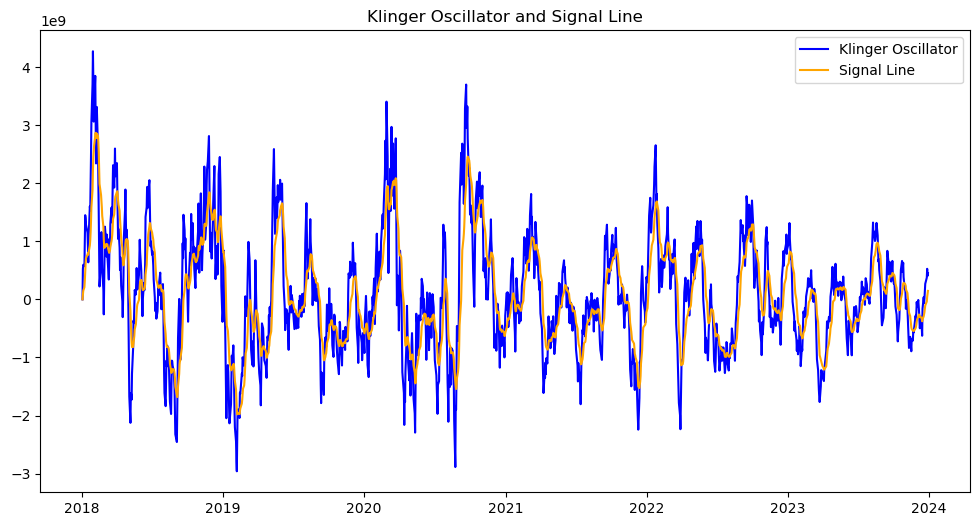

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(data['Klinger Oscillator'], label='Klinger Oscillator', color='blue')
plt.plot(data['Signal Line'], label='Signal Line', color='orange')
plt.title('Klinger Oscillator and Signal Line')
plt.legend()
plt.show()

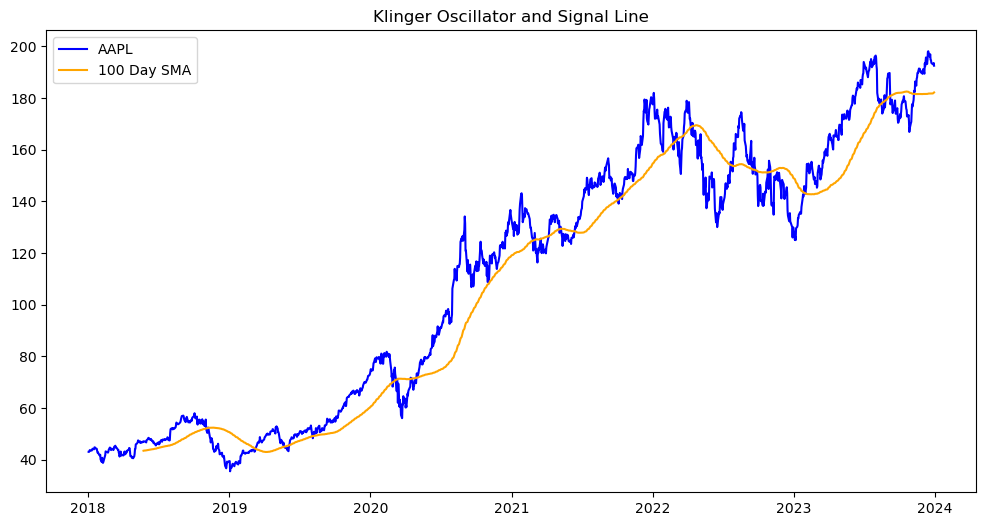

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='AAPL', color='blue')
plt.plot(data['100-day SMA'], label='100 Day SMA', color='orange')
plt.title('Klinger Oscillator and Signal Line')
plt.legend()
plt.show()

In [26]:
def buying_signal(data):
    data['Buying Signal'] = 0
    for i in range(len(data)):
        if(data['Disparity Index'][i] > 0 and data['Klinger Oscillator'][i] > data['Signal Line'][i] and data['Close'][i] > data['100-day SMA'][i]):
            data['Buying Signal'][i] = 1
        if(data['Disparity Index'][i] < 0 and data['Klinger Oscillator'][i] < data['Signal Line'][i] and data['Close'][i] < data['100-day SMA'][i]):
            data['Buying Signal'][i] = -1

In [27]:
buying_signal(data)

C:\Users\DELL\AppData\Local\Temp\ipykernel_12268\3210622252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Buying Signal'][i] = 1
C:\Users\DELL\AppData\Local\Temp\ipykernel_12268\3210622252.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Buying Signal'][i] = -1


In [28]:
print((data['Buying Signal']!=0).sum())

292


In [36]:
def trading(data, take=0.05, stop=0.05):
    initial_portfolio = 100000
    curr_portfolio = initial_portfolio
    trade_on = 0
    loss = []
    profit = []

    entry_index = []
    exit_index = []
    trade_duration = []
    returns = []
    max_drawdown_trade = []
    portfolio = [curr_portfolio]

    for i in range(len(data)):
        if trade_on == 0 and data.iloc[i]['Buying Signal'] == 1:
            cost = data.iloc[i]['Close']
            trade_on = 1
            entry_index.append(i)
            Take = (1 + take) * data.iloc[i]['Close']
            Stop = (1 - stop) * data.iloc[i]['Close']

        elif trade_on == 0 and data.iloc[i]['Buying Signal'] == -1:
            cost = data.iloc[i]['Close']
            trade_on = -1
            entry_index.append(i)
            Take = (1 - take) * data.iloc[i]['Close']
            Stop = (1 + stop) * data.iloc[i]['Close']

        elif trade_on == 1 and (data.iloc[i]['Close'] >= Take or data.iloc[i]['Close'] <= Stop or data.iloc[i]['Buying Signal'] == -1):
            if data.iloc[i]['Close'] >= Take or data.iloc[i]['Buying Signal'] == -1:
                gain = ((data.iloc[i]['Close'] - cost) / cost) * curr_portfolio * 0.8
            else:
                gain = ((Stop - cost) / cost) * curr_portfolio * 0.8
            if gain > 0:
                profit.append(gain)
            else:
                loss.append(gain)
            curr_portfolio += gain
            trade_on = 0
            exit_index.append(i)
            returns.append((gain / initial_portfolio) * 100)
            trade_duration.append(i - entry_index[-1])
            max_drawdown_trade.append((min(data.iloc[entry_index[-1]:i + 1]['Close']) - data.iloc[entry_index[-1]]['Close']) / data.iloc[entry_index[-1]]['Close'] * 100)
            portfolio.append(curr_portfolio)

        elif trade_on == -1 and (data.iloc[i]['Close'] <= Take or data.iloc[i]['Close'] >= Stop or data.iloc[i]['Buying Signal'] == 1):
            if data.iloc[i]['Close'] <= Take or data.iloc[i]['Buying Signal'] == 1:
                gain = ((cost - data.iloc[i]['Close']) / cost) * curr_portfolio * 0.8
            else:
                gain = ((cost - Stop) / cost) * curr_portfolio * 0.8
            if gain > 0:
                profit.append(gain)
            else:
                loss.append(gain)
            curr_portfolio += gain
            trade_on = 0
            exit_index.append(i)
            returns.append((gain / initial_portfolio) * 100)
            trade_duration.append(i - entry_index[-1])
            max_drawdown_trade.append((min(data.iloc[entry_index[-1]:i + 1]['Close']) - data.iloc[entry_index[-1]]['Close']) / data.iloc[entry_index[-1]]['Close'] * 100)
            portfolio.append(curr_portfolio)

    if trade_on != 0:
        current_close_price = data.iloc[-1]['Close']
        if trade_on == 1:
            gain = ((current_close_price - cost) / cost) * curr_portfolio * 0.8
        else:
            gain = ((cost - current_close_price) / cost) * curr_portfolio * 0.8
        if gain > 0:
            profit.append(gain)
        else:
            loss.append(gain)
        curr_portfolio += gain
        exit_index.append(len(data) - 1)
        returns.append((gain / initial_portfolio) * 100)
        trade_duration.append(len(data) - 1 - entry_index[-1])
        max_drawdown_trade.append((min(data.iloc[entry_index[-1]:]['Close']) - data.iloc[entry_index[-1]]['Close']) / data.iloc[entry_index[-1]]['Close'] * 100)
        portfolio.append(curr_portfolio)

    all_trades = profit + loss
    sharpe = math.sqrt(252) * (np.mean(all_trades) / np.std(all_trades))
    print("TOTAL CLOSED TRADES: ", len(profit) + len(loss))
    print("TOTAL WINNING TRADES: ", len(profit))
    print("Largest Losing Trade: ", min(loss) if loss else 0)
    print("Largest winning trade: ", max(profit) if profit else 0)
    print("Sharpe: ", sharpe)
    print("NET: ", sum(all_trades))
    print("Final Portfolio Value:", curr_portfolio)
    print("Initial Portfolio Value:", initial_portfolio)
    print("Maximum Drawdown in percentage: ", str(min(max_drawdown_trade) if max_drawdown_trade else 0), "%")
    print("Net Returns % : ", str(curr_portfolio / initial_portfolio * 100 - 100), "%")
    print("Net holding duration: ", np.mean(trade_duration) if trade_duration else 0)

    trade_log = pd.DataFrame({
        'Entry Index': entry_index,
        'Exit Index': exit_index,
        'Duration': trade_duration,
        'Returns %': returns,
        'Max Drawdown %': max_drawdown_trade
    })
    print(trade_log)

    plt.plot(portfolio, label='Portfolio Value')
    plt.title('Portfolio Value vs Trade Number')
    plt.xlabel('Trade Number')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()

TOTAL CLOSED TRADES:  91
TOTAL WINNING TRADES:  43
Largest Losing Trade:  -8572.011235480504
Largest winning trade:  28506.433840273647
Sharpe:  6.211180794488076
NET:  430023.5224082177
Final Portfolio Value: 530023.522408218
Initial Portfolio Value: 100000
Maximum Drawdown in percentage:  -9.341135434696564 %
Net Returns % :  430.023522408218 %
Net holding duration:  7.681318681318682
    Entry Index  Exit Index  Duration  Returns %  Max Drawdown %
0            99         120        21  -1.600000       -3.178313
1           138         147         9   6.558628       -0.799205
2           161         169         8   5.196927        0.000000
3           176         178         2  -1.762489       -3.767501
4           183         195        12  -1.734289       -2.006428
..          ...         ...       ...        ...             ...
86         1412        1415         3  -8.425929       -3.042464
87         1420        1422         2  -8.291115        0.000000
88         1430        14

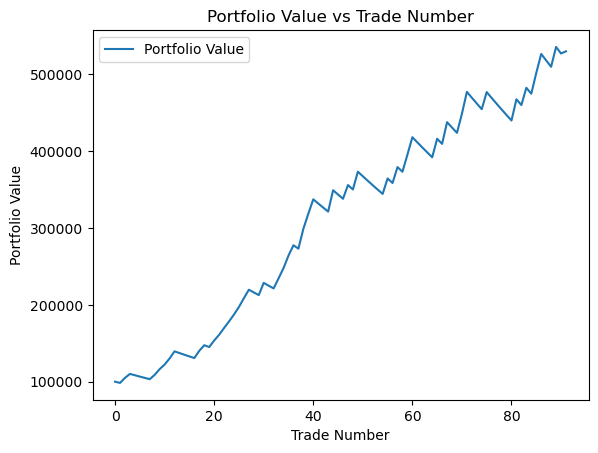

In [54]:
trading(data, 0.06, 0.02)